In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, rc={'figure.figsize':(11,8)}, font_scale=2)

from sklearn.linear_model import Lasso, LassoCV, LassoLarsIC
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [2]:
_DATA_DIR = '/classes/2080001_spr2022/Data'

In [3]:
df = pd.read_csv('%s/loan_train_07_18.csv'%(_DATA_DIR), index_col =0)

# Data visualization

In [4]:
# Data preprocessing, change string type x % to x.
df.revol_util = df.revol_util.apply(lambda x: str(x)[:-1])
df.revol_util = df.revol_util.replace('na','0')
df.revol_util = df.revol_util.astype(np.float64)

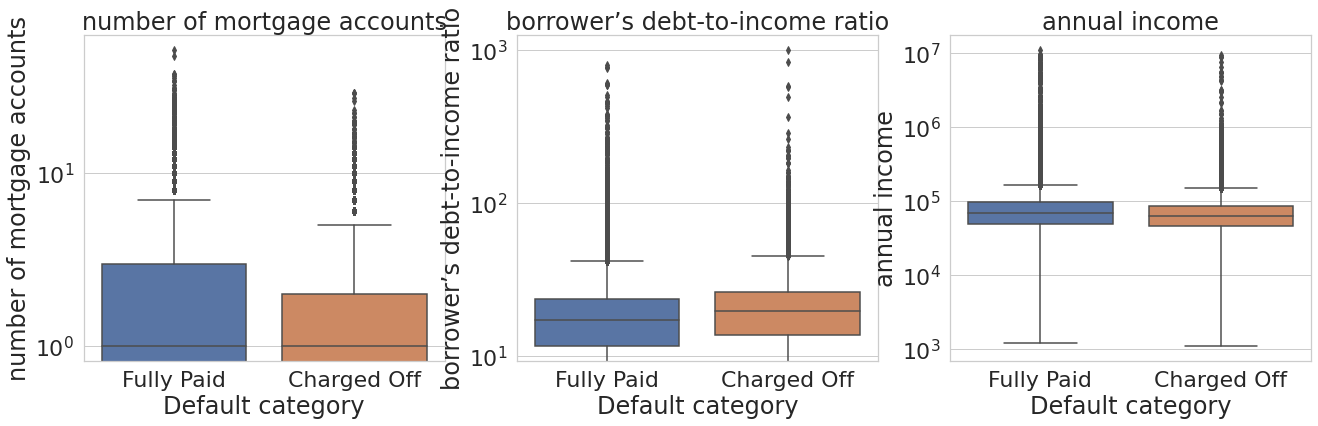

In [5]:
plt.figure(figsize=(22, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="loan_status", y="mort_acc", data=df)

plt.title('number of mortgage accounts')
plt.xlabel('Default category')
plt.ylabel('number of mortgage accounts')
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.boxplot(x="loan_status", y="dti", data=df)

plt.title('borrower’s debt-to-income ratio')
plt.xlabel('Default category')
plt.ylabel('borrower’s debt-to-income ratio')
plt.yscale('log')

plt.subplot(1, 3, 3)
sns.boxplot(x="loan_status", y="annual_inc", data=df)

plt.title('annual income')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Default category')
plt.ylabel('annual income')
plt.yscale('log')



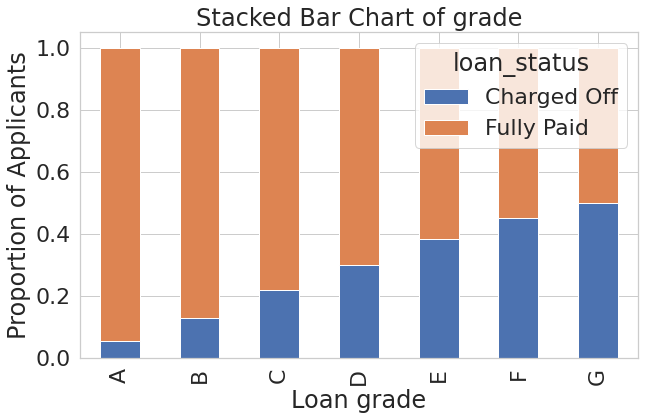

In [6]:
tablegrade = pd.crosstab(df['grade'], df.loan_status)
tablegrade.div(tablegrade.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (10,6))
plt.title('Stacked Bar Chart of grade')
plt.xlabel('Loan grade')
plt.ylabel('Proportion of Applicants')
plt.show();

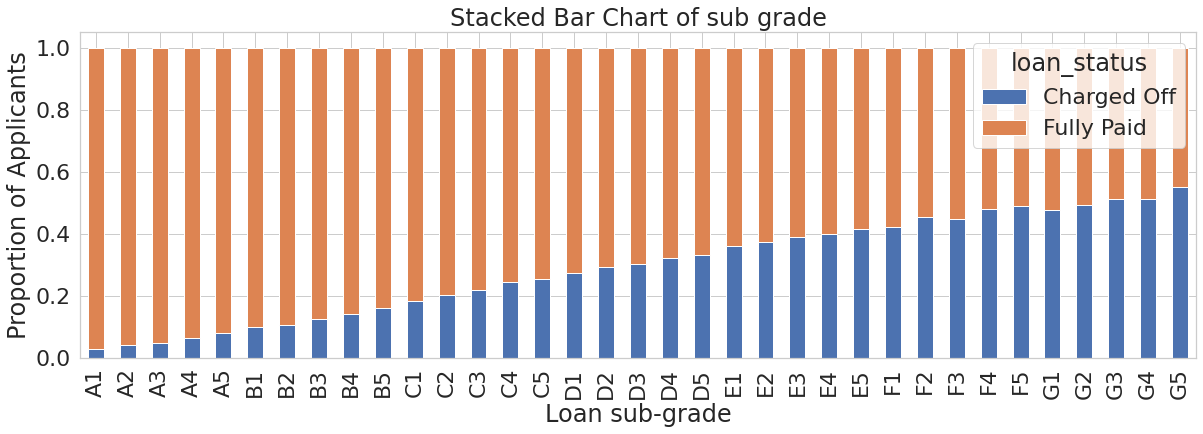

In [7]:
tablesub = pd.crosstab(df['sub_grade'], df.loan_status)
tablesub.div(tablesub.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (20,6))
plt.title('Stacked Bar Chart of sub grade')
plt.xlabel('Loan sub-grade')
plt.ylabel('Proportion of Applicants')
plt.show();

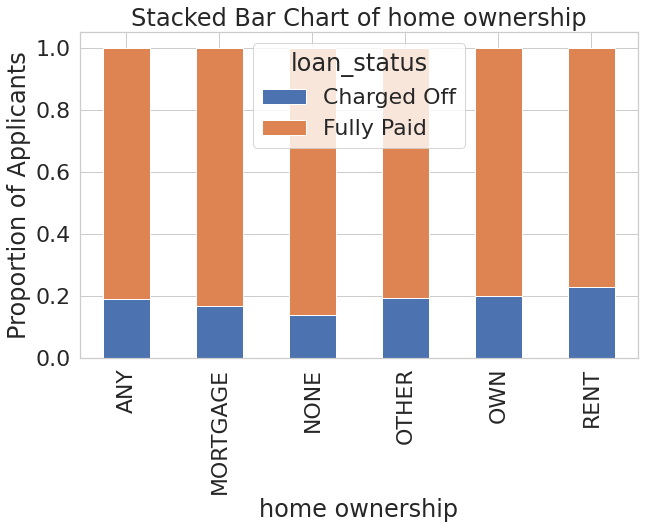

In [8]:
tablehome = pd.crosstab(df['home_ownership'], df.loan_status)
tablehome.div(tablehome.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True,figsize = (10,6))
plt.title('Stacked Bar Chart of home ownership')
plt.xlabel('home ownership')
plt.ylabel('Proportion of Applicants')
plt.show();

In [9]:
temp = df.loc[:,['int_rate','sub_grade','grade']]

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

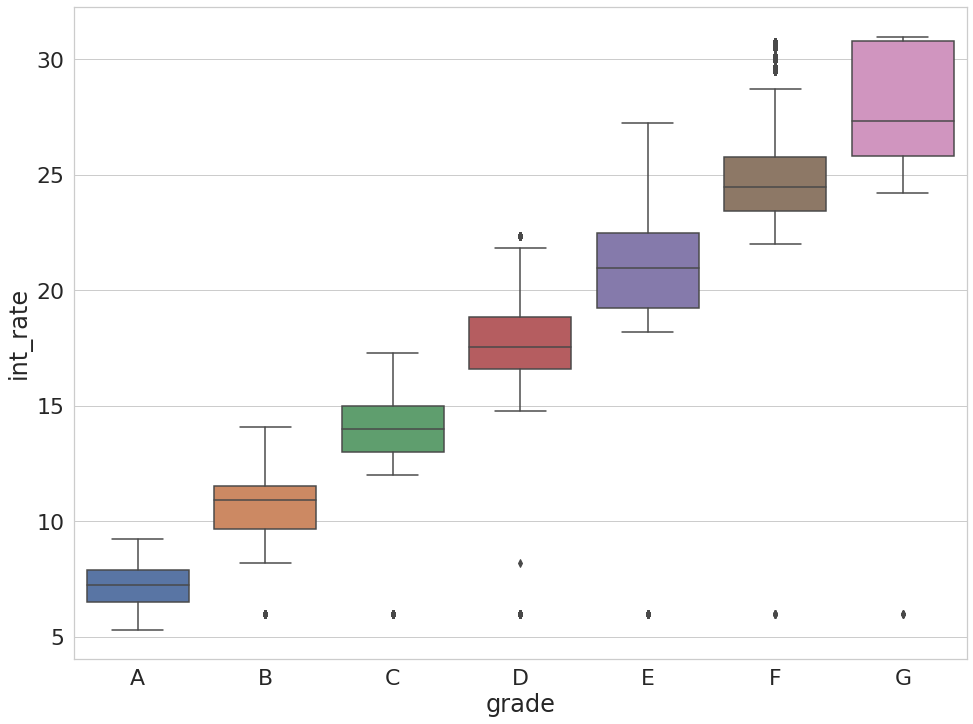

In [10]:
temp = temp.sort_values('grade')
plt.figure(figsize = (16,12))
sns.boxplot(data = temp, x = 'grade', y = 'int_rate')

<AxesSubplot:xlabel='sub_grade', ylabel='int_rate'>

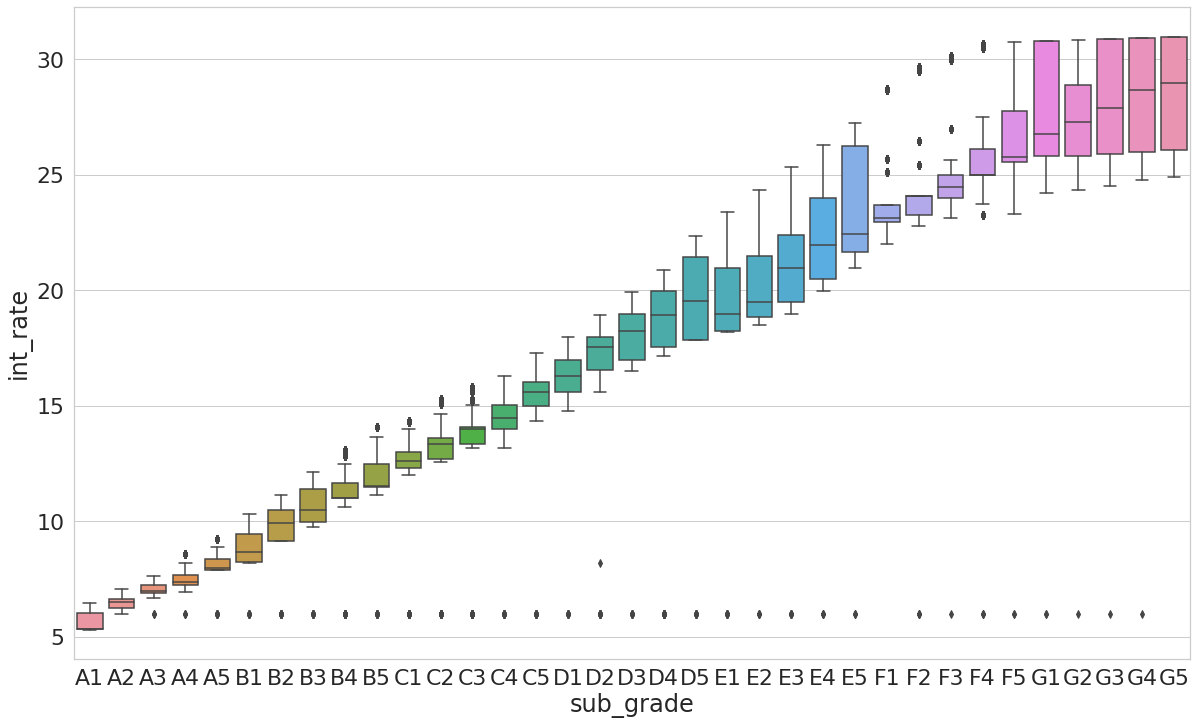

In [11]:
temp = temp.sort_values('sub_grade')
plt.figure(figsize = (20,12))
sns.boxplot(data = temp, x = 'sub_grade', y = 'int_rate')

In [12]:
# Change predicted value into binary numerical value 0,1
status_values = {'Fully Paid': 0, 'Charged Off': 1}
df['loan_status'] = df.loan_status.map(status_values)

In [13]:
df.set_index('id',inplace = True)

Text(0.5, 1.0, 'correlation with loan status')

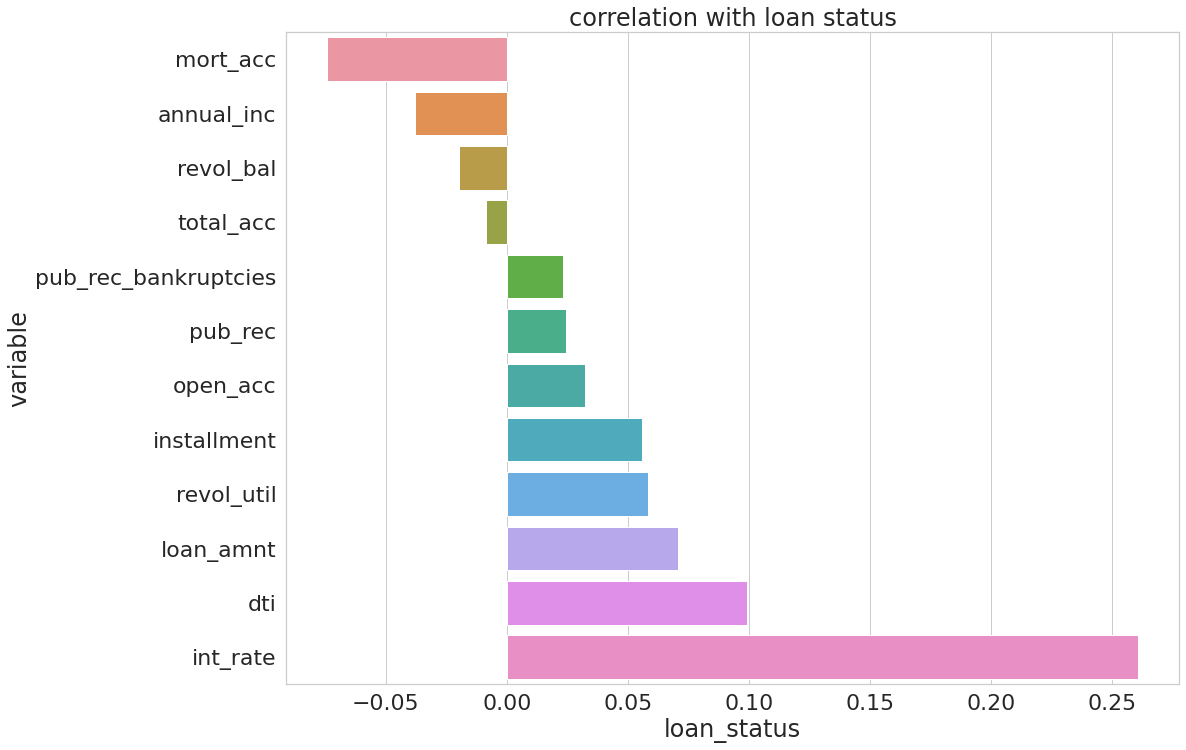

In [14]:
cor = pd.DataFrame(df.corr()['loan_status'].drop('loan_status').sort_values())
cor['variable'] = cor.index

plt.figure(figsize = (16,12))
sns.barplot(
    x="loan_status", 
    y="variable", 
    data=cor, 
    estimator=sum
);
plt.title('correlation with loan status')


# Data cleaning

In [15]:
import sys
sys.path.append('/classes/2080001_spr2022/')

In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
loan_train = pd.read_csv('%s/loan_train_07_18.csv'%(_DATA_DIR), index_col =0)

# Data preprocessing, change string type x % to x.

loan_train.revol_util = loan_train.revol_util.apply(lambda x: str(x)[:-1])
loan_train.revol_util = loan_train.revol_util.replace('na','0')
loan_train.revol_util = loan_train.revol_util.astype(np.float64)

# Change predicted value into binary numerical value 0,1
status_values = {'Fully Paid': 0, 'Charged Off': 1}
loan_train['loan_status'] = loan_train.loan_status.map(status_values)


from Data_cleaning import Data_cleaning, Data_cleaning_grade
loan_train_cleaned = Data_cleaning(loan_train)


In [18]:
# Clean test dataset
loan_test = pd.read_csv('%s/loan_test_19_20.csv'%(_DATA_DIR), index_col =0)

loan_test.int_rate = loan_test.int_rate.apply(lambda x: float(x[:-1]))
loan_test.revol_util = loan_test.revol_util.apply(lambda x: str(x)[:-1])
loan_test.revol_util = loan_test.revol_util.replace('na','0')
loan_test.revol_util = loan_test.revol_util.astype(np.float64)


from Data_cleaning import Data_cleaning, Data_cleaning_grade
loan_test_cleaned = Data_cleaning(loan_test)

status_values = {'Fully Paid': 0, 'Charged Off': 1}
loan_test_cleaned ['loan_status'] = loan_test_cleaned .loan_status.map(status_values)


In [19]:
loan_train_cleaned.loan_status.mean()

0.1963565976126903

In [20]:
loan_test_cleaned.loan_status.mean()

0.19311832216143168

In [21]:
grade_col = np.unique(loan_train[['grade']])
subgrade_col = np.unique(loan_train[['sub_grade']])

In [22]:
from sklearn.linear_model import LogisticRegression

def Model_construction(X_train,y_train,method,penalty):
    
    Xscaler = StandardScaler().fit(X_train) 
    X_train = Xscaler.transform(X_train)    
    
    if method == 'Imbalanced':
        if  penalty == 'l1':
            lr_model = LogisticRegression(class_weight='balanced',penalty = 'l1',solver ='saga').fit(X_train,y_train)
        if penalty == 'none':  
            lr_model = LogisticRegression(class_weight='balanced').fit(X_train,y_train)
    
    if method == 'Null':
        if penalty == 'l1':
            lr_model = LogisticRegression(penalty = 'l1',solver ='saga').fit(X_train,y_train)
        if penalty == 'none':
            lr_model = LogisticRegression().fit(X_train,y_train)
    
    return lr_model, Xscaler

In [23]:
X_train = loan_train_cleaned.drop(columns = ['int_rate','loan_status','grade','sub_grade','id'])
y_train = loan_train_cleaned.loan_status

X_test = loan_test_cleaned.drop(columns = ['int_rate','loan_status','grade','sub_grade','id'])
y_test = loan_test_cleaned.loan_status

In [24]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)  

lr_model = LogisticRegression().fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred = lr_model.predict(X_test)
    


In [25]:
df_summary = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})

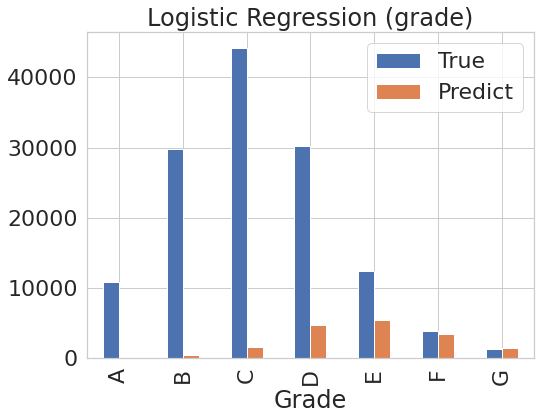

In [26]:
df_summary.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression (grade)')
plt.savefig('lg_grade.pdf')

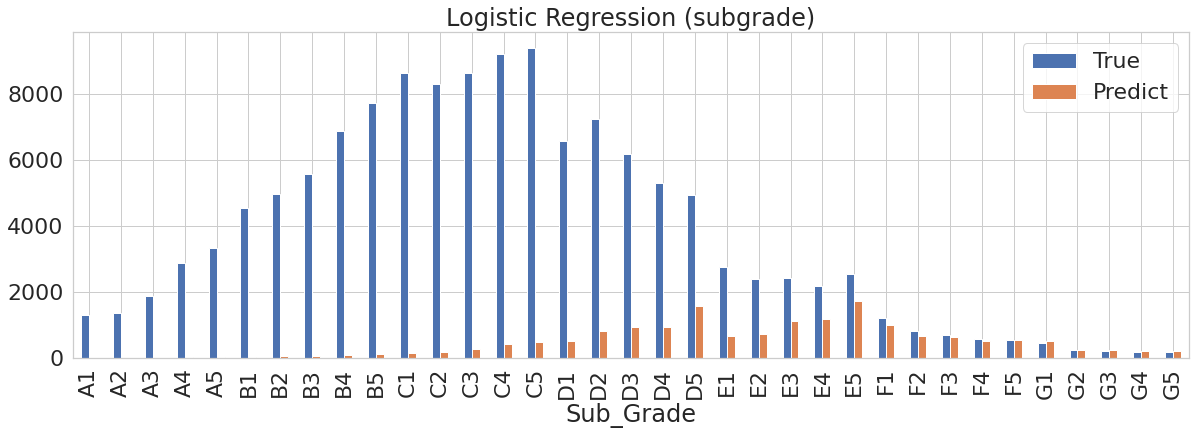

In [27]:
df_summary.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression (subgrade)')
plt.savefig('lg_subgrade.pdf')

In [28]:
# Lasso
lr_model = LogisticRegression(penalty = 'l1',solver = 'saga',C=100).fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred = lr_model.predict(X_test)

df_summary_lasso = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})
    

Text(0.5, 1.0, 'Logistic Regression, Lasso(grade)')

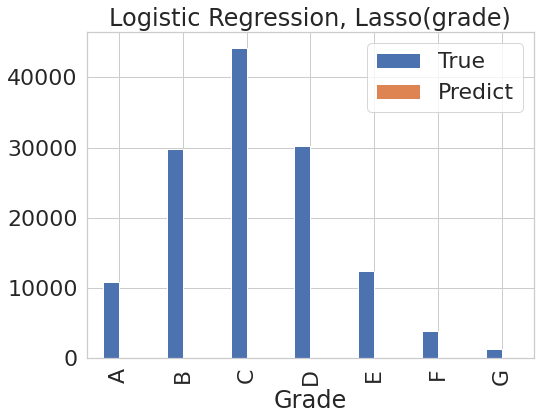

In [29]:
df_summary_lasso.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression, Lasso(grade)')

In [30]:
df_summary_lasso.groupby('Grade').sum()

,True,Predict
Grade,,
A,10825,21
B,29750,29
C,44210,17
D,30274,18
E,12356,7
F,3896,3
G,1302,0


Text(0.5, 1.0, 'Logistic Regression, Lasso (subgrade)')

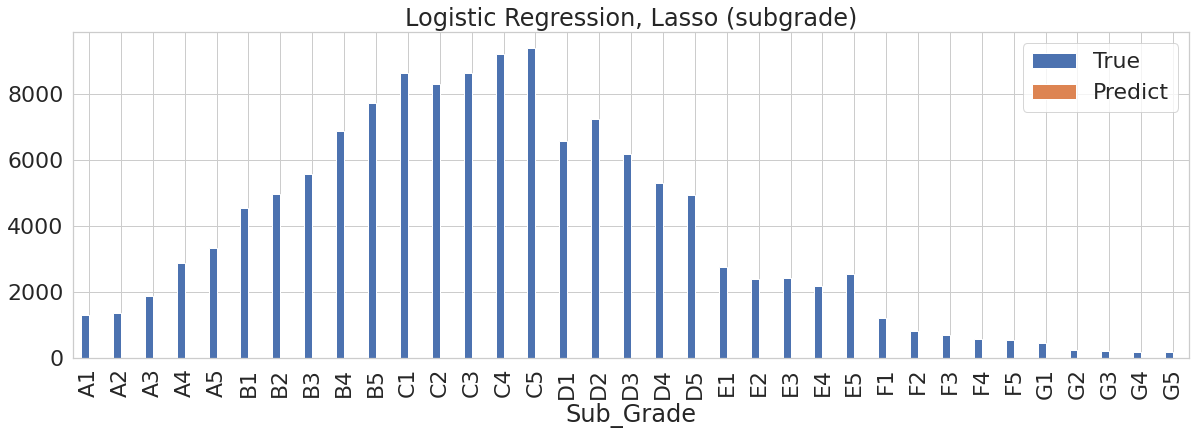

In [31]:
df_summary_lasso.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression, Lasso (subgrade)')

In [32]:
# Two variable logistic regression
X_train_2 = loan_train_cleaned[['mort_acc','dti']]

X_test_2 = loan_test_cleaned[['mort_acc','dti']]


lr_model = LogisticRegression().fit(X_train_2,y_train)


y_pred = lr_model.predict(X_test_2)
    

df_summary_2 = pd.DataFrame({'Grade': loan_test_cleaned.grade,'Sub_Grade':loan_test_cleaned.sub_grade,'True':y_test,'Predict':y_pred})
 

Text(0.5, 1.0, 'Logistic Regression, 2 variables (grade)')

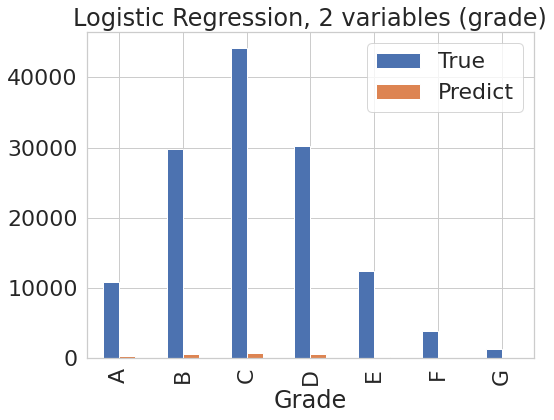

In [33]:
df_summary_2.groupby('Grade').sum().plot(kind ='bar', figsize = (8,6))
plt.title('Logistic Regression, 2 variables (grade)')

Text(0.5, 1.0, 'Logistic Regression, 2 variables (subgrade)')

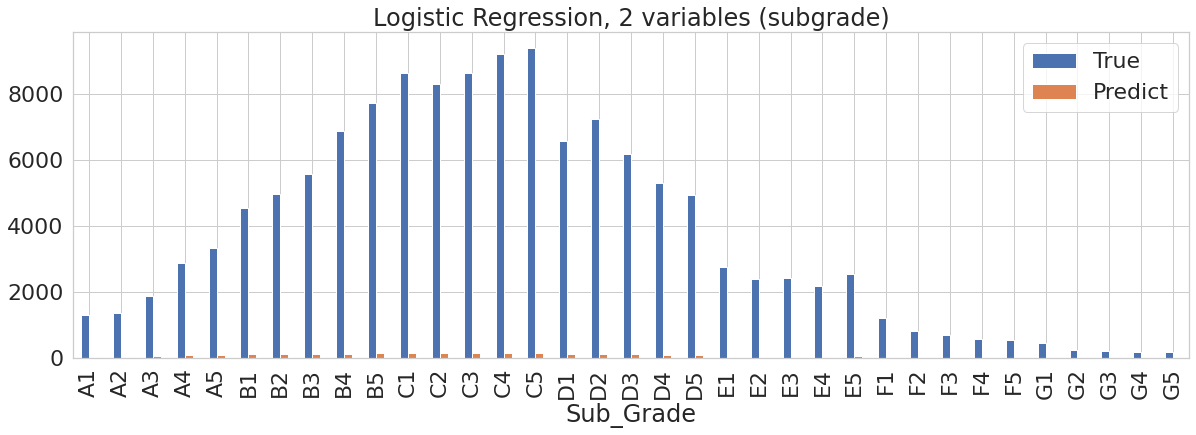

In [34]:
df_summary_2.groupby('Sub_Grade').sum().plot(kind ='bar', figsize = (20,6))
plt.title('Logistic Regression, 2 variables (subgrade)')

# KNN with sklearn

In [35]:
knn_train = loan_train_cleaned[['id','loan_status','mort_acc','dti','grade','sub_grade']]

knn_test = loan_test_cleaned [['id','loan_status','mort_acc','dti','grade','sub_grade']]


In [36]:
# standardize

# X = df_knn.drop(columns = 'loan_status')
X_train = knn_train[['mort_acc','dti']]
y_train = knn_train[['loan_status']]

Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)


X_test = knn_test[['mort_acc','dti']]
y_test = knn_test[['loan_status']]


X_test = Xscaler.transform(X_test)

nn1 = KNeighborsClassifier(n_neighbors=1,n_jobs=-1).fit(X_train, y_train)
nn5 = KNeighborsClassifier(n_neighbors=5,n_jobs=-1).fit(X_train, y_train)
nn20 = KNeighborsClassifier(n_neighbors=20,n_jobs=-1).fit(X_train, y_train)

y_pred_1 = nn1.predict(X_test) 
y_pred_5 = nn5.predict(X_test) 
y_pred_20 = nn20.predict(X_test)



In [37]:
knn_result = pd.DataFrame(columns = ['Grade','Sub_Grade','True','1-nn','5-nn','20-nn'])

knn_result.loc[:,'Grade'] = knn_test.loc[:,'grade']
knn_result.loc[:,'Sub_Grade'] = knn_test.loc[:,'sub_grade']
knn_result.loc[:,'True'] = y_test.loan_status
knn_result.loc[:,'1-nn'] = y_pred_1 
knn_result.loc[:,'5-nn'] = y_pred_5
knn_result.loc[:,'20-nn'] = y_pred_20

<AxesSubplot:xlabel='Grade'>

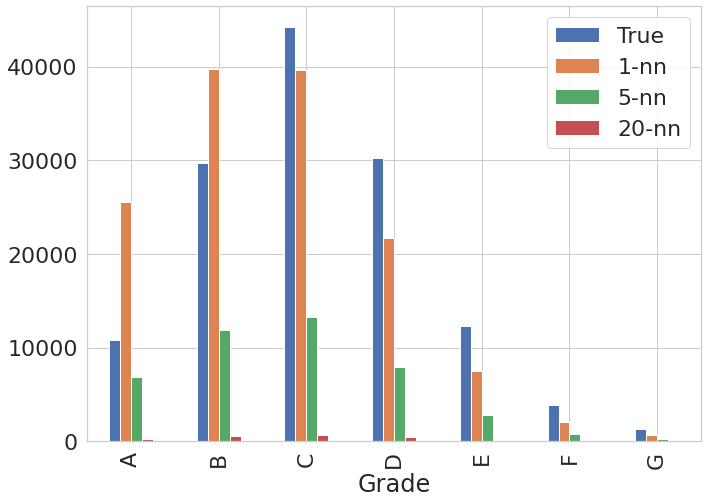

In [38]:
knn_result.groupby('Grade').sum().plot(kind = 'bar')

<AxesSubplot:xlabel='Sub_Grade'>

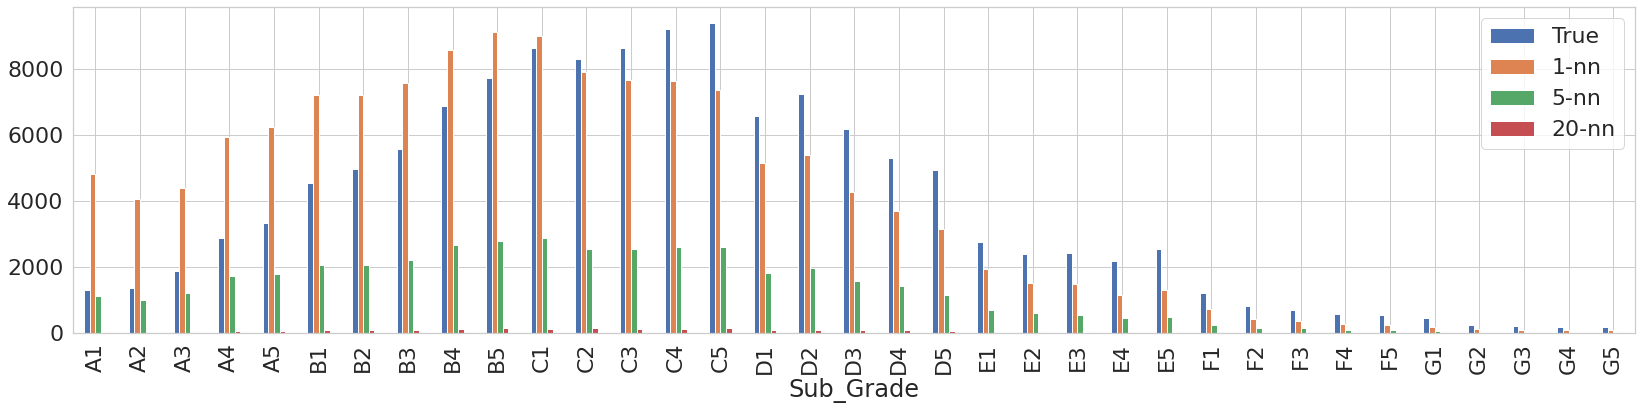

In [39]:
knn_result.groupby('Sub_Grade').sum().plot(kind = 'bar', figsize = (28,6))

# Model evaluation

## Confusion matrix

In [40]:
# Construct the confusion matrix
CM_1 = confusion_matrix(y_test.loan_status,knn_result['1-nn'])
CM_5 =  confusion_matrix(y_test.loan_status,knn_result['5-nn'])
CM_20 =  confusion_matrix(y_test.loan_status,knn_result['20-nn'])

# Calculate Accuracy
Acc_1 = (CM_1[0,0] + CM_1[1,1])/CM_1.sum()
Acc_5 = (CM_5[0,0] + CM_5[1,1])/CM_5.sum()
Acc_20 = (CM_20[0,0] + CM_20[1,1])/CM_20.sum()

# Calculate FPR & FNR

FPR_1 = CM_1[0,1] / (CM_1[0,1]+CM_1[0,0])
FPR_5 = CM_5[0,1] / (CM_5[0,1]+CM_5[0,0])
FPR_20 = CM_20[0,1] / (CM_20[0,1]+CM_20[0,0])


FNR_1 = CM_1[1,0] / (CM_1[1,0]+CM_1[1,1])
FNR_5 = CM_5[1,0] / (CM_5[1,0]+CM_5[1,1])
FNR_20 = CM_20[1,0] / (CM_20[1,0]+CM_20[1,1])


print('---Calculate Accuracy---')
print('1-NN:', Acc_1)
print('5-NN:', Acc_5)
print('20-NN:', Acc_20)
print('------------------------')
print('-----Calculate FPR------')
print('1-NN:', FPR_1)
print('5-NN:', FPR_5)
print('20-NN:', FPR_20)
print('------------------------')
print('-----Calculate FNR------')
print('1-NN:', FNR_1)
print('5-NN:', FNR_5)
print('20-NN:', FNR_20)
print('------------------------')


---Calculate Accuracy---
1-NN: 0.6897157827442539
5-NN: 0.7717742863259127
20-NN: 0.8052739725029963
------------------------
-----Calculate FPR------
1-NN: 0.19591575223794397
5-NN: 0.061222206179613055
20-NN: 0.0030049812301472714
------------------------
-----Calculate FNR------
1-NN: 0.7881354015066396
5-NN: 0.9259951890086191
20-NN: 0.995769645509867
------------------------


In [41]:
CM_5

array([[520158,  33922],
       [122799,   9814]])

In [42]:
CM_20

array([[552415,   1665],
       [132052,    561]])

In [43]:
# Logistic regression result

lg_null = confusion_matrix(y_test.loan_status,df_summary.Predict)
lg_2 =  confusion_matrix(y_test.loan_status,df_summary_2.Predict)
lg_lasso =  confusion_matrix(y_test.loan_status,df_summary_lasso.Predict)

# Calculate Accuracy
Acc_lg_null = (lg_null[0,0] + lg_null[1,1])/lg_null.sum()
Acc_lg_2 = (lg_2[0,0] + lg_2[1,1])/lg_2.sum()
Acc_lg_lasso = (lg_lasso[0,0] + lg_lasso[1,1])/lg_lasso.sum()

# Calculate FPR & FNR

FPR_null = lg_null[0,1] / (lg_null[0,1]+lg_null[0,0])
FPR_2 = lg_2[0,1] / (lg_2[0,1]+lg_2[0,0])
FPR_lasso = lg_lasso[0,1] / (lg_lasso[0,1]+lg_lasso[0,0])


FNR_null = lg_null[1,0] / (lg_null[1,0]+lg_null[1,1])
FNR_2 = CM_5[1,0] / (lg_2[1,0]+lg_2[1,1])
FNR_lasso = lg_lasso[1,0] / (lg_lasso[1,0]+lg_lasso[1,1])

print('---Calculate Accuracy---')
print('Logistic regression (plain):',Acc_lg_null)
print('Logistic regression 2 variables:', Acc_lg_2)
print('Logistic regression lasso:', Acc_lg_lasso)
print('------------------------')
print('-----Calculate FPR------')
print('Logistic regression (plain):',FPR_null)
print('Logistic regression 2 variables:', FPR_2)
print('Logistic regression lasso:', FPR_lasso)
print('------------------------')
print('-----Calculate FNR------')
print('Logistic regression (plain):',FNR_null)
print('Logistic regression 2 variables:', FNR_2)
print('Logistic regression lasso:', FNR_lasso)



---Calculate Accuracy---
Logistic regression (plain): 0.8052317411128408
Logistic regression 2 variables: 0.8053584352833071
Logistic regression lasso: 0.8067957588034246
------------------------
-----Calculate FPR------
Logistic regression (plain): 0.016571614207334683
Logistic regression 2 variables: 0.003333453652902108
Logistic regression lasso: 0.00013896910193473866
------------------------
-----Calculate FNR------
Logistic regression (plain): 0.9393045930640284
Logistic regression 2 variables: 0.9259951890086191
Logistic regression lasso: 0.9998642667008514


In [44]:
lg_null

array([[544898,   9182],
       [124564,   8049]])

## ROC & AUC

In [45]:
# Logistic regression
Xscaler = StandardScaler().fit(X_train) 
X_train = Xscaler.transform(X_train)  

lr_model = LogisticRegression().fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred_pro = lr_model.predict_proba(X_test)[:,1]

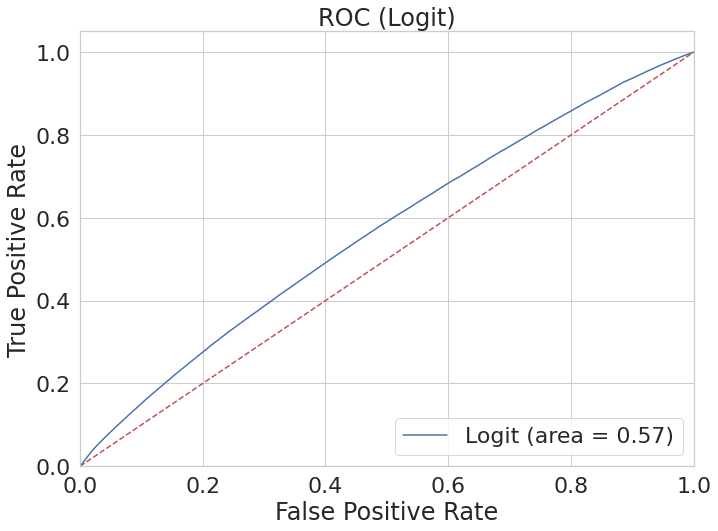

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pro)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit)')
plt.legend(loc='lower right')
plt.savefig('ROC.pdf')

In [47]:
# Logistic regression with Lasso
lr_model = LogisticRegression(penalty = 'l1',solver = 'saga').fit(X_train,y_train)

X_test =  Xscaler.transform(X_test)  

y_pred_pro_lasso = lr_model.predict_proba(X_test)[:,1]

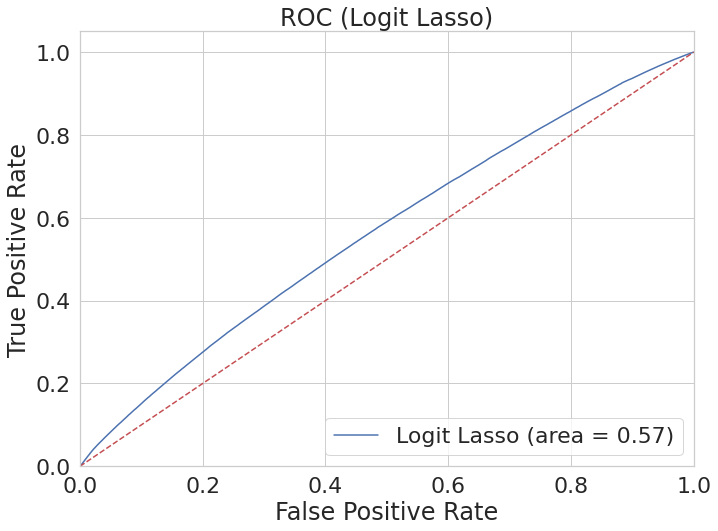

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_pro_lasso)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit Lasso (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit Lasso)')
plt.legend(loc='lower right')
#plt.savefig('ROC.pdf')

In [49]:
# Two variable logistic regression
lr_model = LogisticRegression().fit(X_train_2,y_train)


y_pred_prob_2 = lr_model.predict_proba(X_test_2)[:,1]    

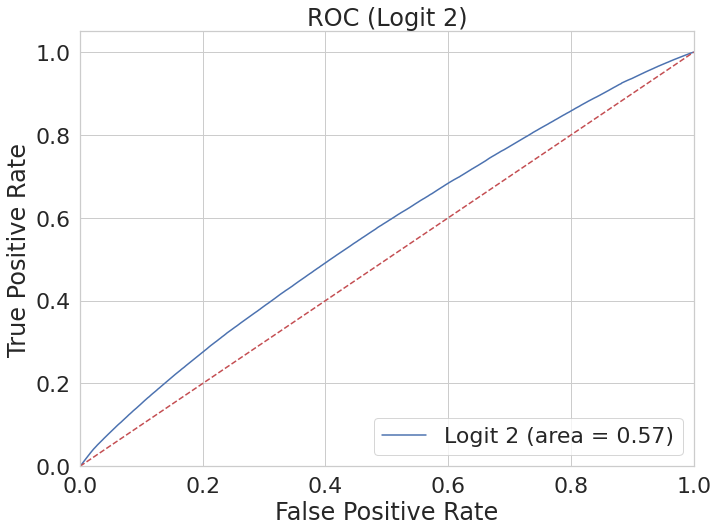

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_2)

roc_auc = auc(fpr,tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logit 2 (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Logit 2)')
plt.legend(loc='lower right')
#plt.savefig('ROC.pdf')

# Multinomial Logistic Regression

In [51]:
import random
from data_utils import load_CIFAR10

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



In [52]:
# Load data
Xtr, Ytr, Xte, Yte = load_CIFAR10(_DATA_DIR+'/cifar-10-data') 

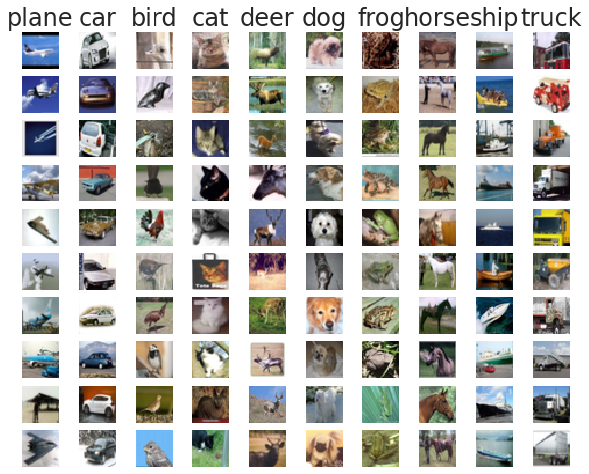

In [53]:
# Visualize some examples from the dataset.
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Ytr== y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(Xtr[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

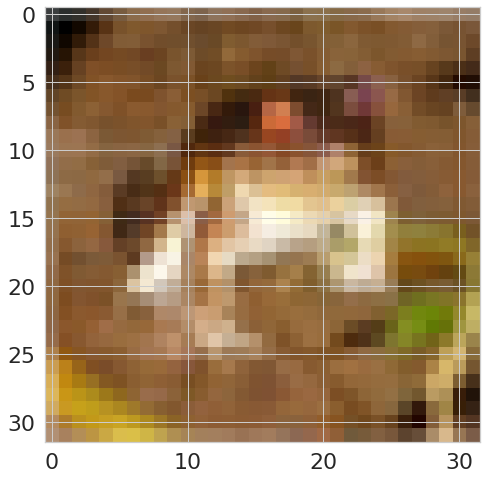

In [54]:
# Data example
# It's a frog
plt.imshow(Xtr[0]/255)

In [55]:
classes[Ytr[0]]

'frog'

In [56]:
Xtr.shape

(50000, 32, 32, 3)

In [57]:
# flatten out all images to be one-dimensional
Xtr_rows = Xtr.reshape(Xtr.shape[0], 32 * 32 * 3) # Xtr_rows becomes 50000 x 3072
Xte_rows = Xte.reshape(Xte.shape[0], 32 * 32 * 3) # Xte_rows becomes 10000 x 3072

In [58]:
# logistic regression
from sklearn.linear_model import LogisticRegression
MLR = LogisticRegression(multi_class='multinomial', solver='saga',random_state=0)
MLR.fit(Xtr_rows[:5000], Ytr[:5000])

y_pred_MLR = MLR.predict(Xte_rows[:1000])

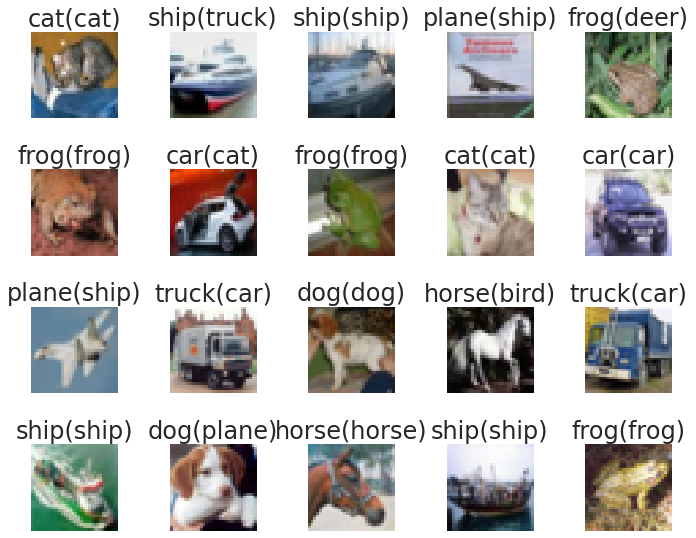

In [59]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(Xte[i]/255)
    plt.title(classes[Yte[i]]+'('+classes[y_pred_MLR[i]]+')')
    plt.axis('off')
plt.tight_layout()

In [60]:
CIFAR10_result = pd.DataFrame({'True':Yte[:1000],'Predict':y_pred_MLR})
CIFAR10_result['Correct'] = CIFAR10_result.iloc[:,0] - CIFAR10_result.iloc[:,1]
Acc_cifar = (CIFAR10_result['Correct'] == 0).sum()/CIFAR10_result.shape[0]

In [61]:
Acc_cifar 

0.334

In [62]:
# Top 5 error
y_pred_prob = MLR.predict_proba(Xte_rows[:1000])

predict_prob = pd.DataFrame(y_pred_prob)
predict_prob.columns = classes

In [63]:
predict_prob

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0.021014,0.188227,0.157244,0.352709,0.003062,0.019604,0.123683,0.000877,0.133507,0.000074
1,0.023289,0.152691,0.026497,0.011955,0.002931,0.002541,0.000289,0.000909,0.108290,0.670607
2,0.302096,0.074267,0.055328,0.035290,0.002804,0.035317,0.001594,0.008702,0.316940,0.167662
3,0.183162,0.014421,0.140843,0.023193,0.057845,0.075972,0.003896,0.204206,0.268059,0.028404
4,0.007070,0.029614,0.071359,0.005303,0.810436,0.023798,0.007290,0.012639,0.030594,0.001897
...,...,...,...,...,...,...,...,...,...,...
995,0.081639,0.047239,0.095909,0.041384,0.085904,0.041121,0.069389,0.512160,0.001114,0.024141
996,0.270766,0.027977,0.136682,0.018511,0.020501,0.030782,0.007460,0.036350,0.125133,0.325838
997,0.119362,0.089789,0.366755,0.005659,0.037534,0.195427,0.004559,0.016499,0.038214,0.126202
998,0.058912,0.282285,0.136665,0.071686,0.036601,0.180905,0.014772,0.162419,0.016443,0.039313


In [64]:
Top_5 = pd.DataFrame(np.argsort(y_pred_prob)[:,-5:])
Top_5['True'] = Yte[:1000]
Top_5['Correct'] = (Top_5['True'] - Top_5[4]) * (Top_5['True'] - Top_5[3]) * (Top_5['True'] - Top_5[2]) * (Top_5['True'] - Top_5[1]) * (Top_5['True']-Top_5[0])
(Top_5['Correct'] == 0).sum()/Top_5.shape[0]

0.846